In [119]:
import vtk

g_test_vtk = False

def vtk_show(renderer, w=100, h=100):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(w, h)
    renderWindow.Render()
     
    windowToImageFilter = vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    from IPython.display import Image
    return Image(data)

from vtk import (vtkSphereSource, vtkPolyDataMapper, vtkActor, vtkRenderer,
        vtkRenderWindow, vtkWindowToImageFilter, vtkPNGWriter)

def vtk_test_render_sphere():
    sphereSource = vtkSphereSource()
    sphereSource.SetPhiResolution(200)
    sphereSource.SetThetaResolution(200)
    mapper = vtkPolyDataMapper()
    mapper.SetInputConnection(sphereSource.GetOutputPort())

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1,1,0)

    renderer = vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)

    return renderer

if g_test_vtk:
    vtk_show(vtk_test_render_sphere(), 200, 200)

def vtk_test_render_bunny():
    reader = vtkOBJReader()
    reader.SetFileName('./data/bunny.obj')
    mapper = vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1,1,0)

    renderer = vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)

    return renderer

vtk_show(vtk_test_render_bunny(), 200, 200)

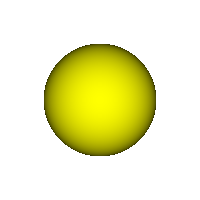

In [5]:
from vtk import (vtkSphereSource, vtkPolyDataMapper, vtkActor, vtkRenderer,
        vtkRenderWindow, vtkWindowToImageFilter, vtkPNGWriter)

def vtk_test_render_sphere():
    sphereSource = vtkSphereSource()
    sphereSource.SetPhiResolution(200)
    sphereSource.SetThetaResolution(200)
    mapper = vtkPolyDataMapper()
    mapper.SetInputConnection(sphereSource.GetOutputPort())

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1,1,0)

    renderer = vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)

    return renderer

vtk_show(vtk_test_render_sphere(), 200, 200)

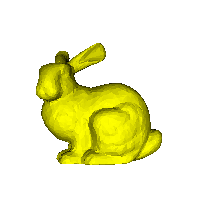

In [6]:
from vtk import (vtkOBJReader)

def vtk_test_render_bunny():
    reader = vtkOBJReader()
    reader.SetFileName('./data/bunny.obj')
    mapper = vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1,1,0)

    renderer = vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)
    
    return renderer

vtk_show(vtk_test_render_bunny(), 200, 200)

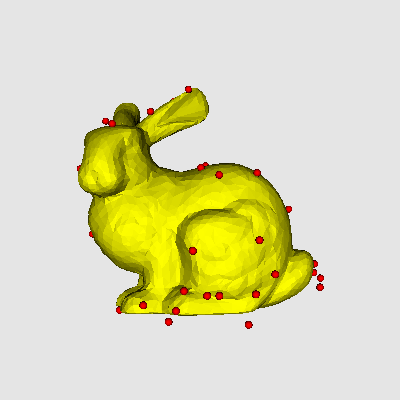

In [118]:
from vtk import (vtkTriangleFilter)
import random

reader = vtkOBJReader()
reader.SetFileName('./data/bunny.obj')
mapper = vtkPolyDataMapper()
mapper.SetInputConnection(reader.GetOutputPort())

actor = vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(1,1,0)

renderer = vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0.9, 0.9, 0.9)
    
obbTree = vtk.vtkOBBTree()
#obbTree.SetDataSet(mesh)
reader.Update()
obbTree.SetDataSet(reader.GetOutput())
obbTree.BuildLocator()
#print obbTree

for i in range(200):

    points = vtk.vtkPoints()
    cellIds = vtk.vtkIdList()


    code = obbTree.IntersectWithLine((200.0 * random.uniform(-1, 1), 200.0 * random.uniform(-1, 1), 200.0 * random.uniform(-1, 1)), (0.0, 0.0, 0.0), points, cellIds)
    #print points.GetPoint(0)
    #code = obbTree.IntersectWithLine((100.0, 100.0, 0.0), (0.0, 5550.0, 0.0), points, cellIds)
    #print points
    
    #print points.GetNumberOfPoints()
    if points.GetNumberOfPoints() > 0:

        #print points[0]
        source = vtk.vtkSphereSource()
        source.SetPhiResolution(200)
        source.SetThetaResolution(200)
        source.SetCenter(points.GetPoint(0))
        source.SetRadius(0.0025)

        pointMapper = vtk.vtkPolyDataMapper()
        pointMapper.SetInputConnection(source.GetOutputPort())
        actor = vtkActor()
        actor.SetMapper(pointMapper)
        actor.GetProperty().SetColor(1,0,0)
        renderer.AddActor(actor)

#print reader.GetOutput().GetBounds()

vtk_show(renderer, 400, 400)

